# 載入所需套件

In [1]:
import requests
from bs4 import BeautifulSoup
from datetime import datetime,timedelta
from tqdm import tqdm
import pandas_datareader as pdr
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import pandas as pd
from pandas.plotting import register_matplotlib_converters
%matplotlib inline

register_matplotlib_converters()
#設定字體和解決圖像中文顯示問題
plt.rcParams['font.sans-serif']=['Microsoft JhengHei']
plt.rcParams['axes.unicode_minus']=False

# 爬取期交所選擇權交易變動資料

In [2]:
def pc_ratio_crawler(startdate,enddate):
    startdate=startdate.strftime('%Y/%m/%d')
    enddate=enddate.strftime('%Y/%m/%d')
    url='https://www.taifex.com.tw/cht/3/pcRatio'

    payload={
        'queryStartDate':'{}'.format(startdate),
        'queryEndDate':'{}'.format(enddate)
    }

    response=requests.post(url,data=payload)
    dfs=pd.read_html(response.text)
    df=dfs[3]
    
    return df

In [3]:
dfs=[]
enddate=datetime.now().date()
startdate=(enddate-timedelta(days=30))

for i in tqdm(range(60)):
    df=pc_ratio_crawler(startdate,enddate)
    dfs.append(df)
    enddate=startdate-timedelta(days=1)
    startdate=enddate-timedelta(days=30)

100%|██████████████████████████████████████████████████████████████████████████████████| 60/60 [00:47<00:00,  1.36it/s]


In [4]:
option=pd.concat(dfs,ignore_index=True)
option.set_index('日期',inplace=True)
option.index=pd.to_datetime(option.index.map(str),format='%Y-%m-%d')
option.to_csv('pc比率.csv')

In [5]:
option.head()

,賣權成交量,買權成交量,買賣權成交量比率%,賣權未平倉量,買權未平倉量,買賣權未平倉量比率%
日期,,,,,,
2020-01-20,216646,167584,129.28,321685,212915,151.09
2020-01-17,219122,197578,110.90,287146,192666,149.04
2020-01-16,212554,176779,120.24,248833,163652,152.05
2020-01-15,575697,543742,105.88,188760,119829,157.52
2020-01-14,411870,367042,112.21,506310,334734,151.26


# 抓取yahoo finance台灣加權股價指數資料

In [6]:
start=option.index[-1]
end=option.index[0]
taiex=pdr.DataReader('^TWII','yahoo',start=start,end=end)

In [7]:
taiex.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2014-12-24,9186.179688,9096.480469,9096.480469,9186.179688,2610200.0,9186.145508
2014-12-25,9198.040039,9153.769531,9186.830078,9158.700195,1831400.0,9158.666016
2014-12-26,9214.070312,9158.389648,9171.910156,9214.070312,1649700.0,9214.036133
2014-12-29,9313.330078,9216.429688,9216.429688,9286.280273,2137000.0,9286.246094
2014-12-30,9338.059570,9262.700195,9299.099609,9268.429688,1891600.0,9268.395508


# 繪製比較圖

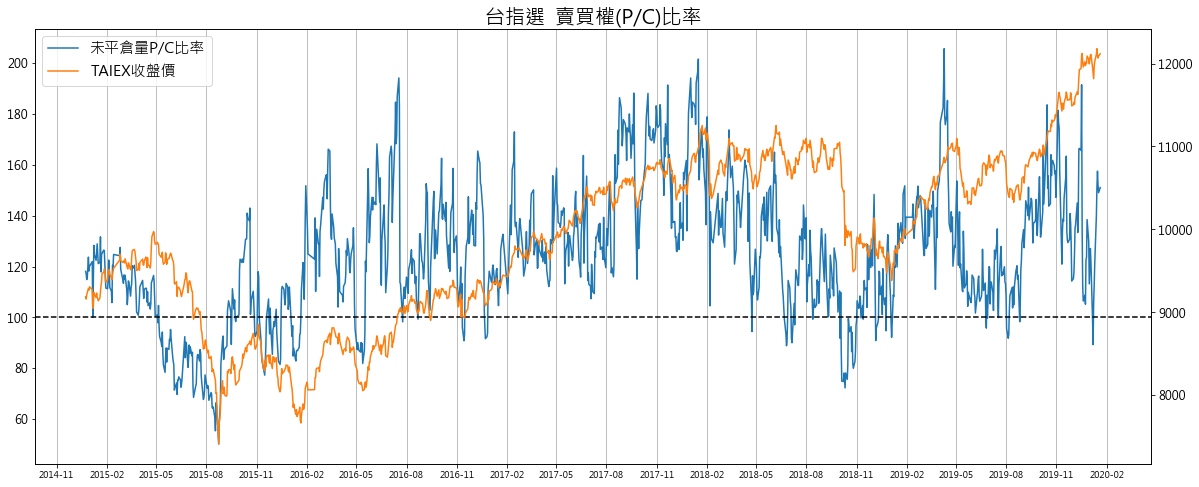

In [8]:
fig,ax=plt.subplots(figsize=(20,8))
ax2=ax.twinx()
ax.plot(option.index,option['買賣權未平倉量比率%'],label='未平倉量P/C比率')
ax2.plot(taiex.index,taiex['Adj Close'],label='TAIEX收盤價',color='#ff7f0e')
lines=ax.get_lines()+ax2.get_lines()
ax.legend(lines,[line.get_label() for line in lines],fontsize=15,loc='upper left')
ax.set_title('台指選  賣買權(P/C)比率',fontsize=20)
ax.axhline(y=100,color='k',linestyle='--')
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
ax.tick_params(axis='x',labelsize=9)
ax.tick_params(axis='y',labelsize=12)
ax.grid(axis='x')
ax2.tick_params(axis='y',labelsize=12)

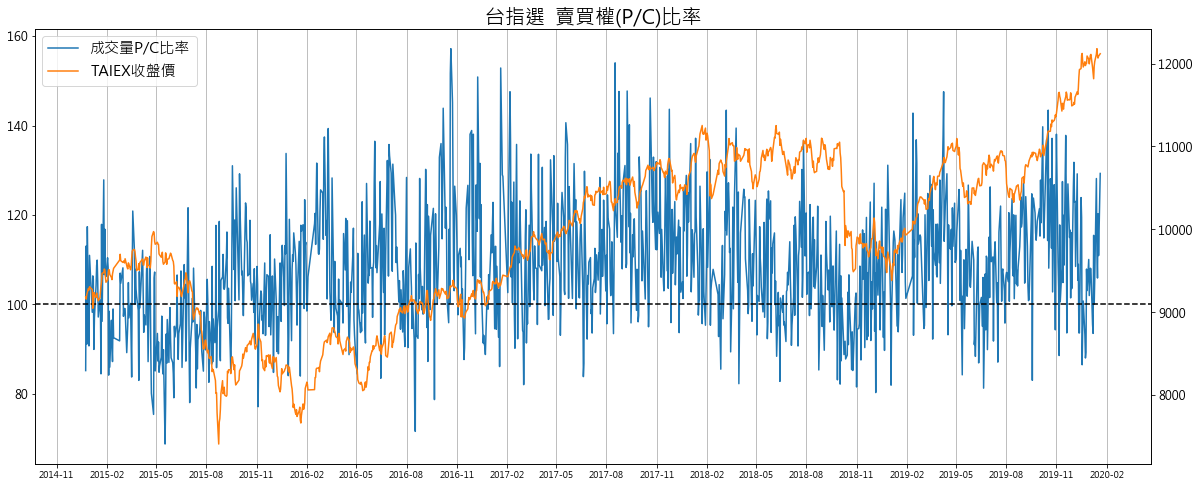

In [9]:
fig,ax=plt.subplots(figsize=(20,8))
ax2=ax.twinx()
ax.plot(option.index,option['買賣權成交量比率%'],label='成交量P/C比率')
ax2.plot(taiex.index,taiex['Adj Close'],label='TAIEX收盤價',color='#ff7f0e')
lines=ax.get_lines()+ax2.get_lines()
ax.legend(lines,[line.get_label() for line in lines],fontsize=15,loc='upper left')
ax.set_title('台指選  賣買權(P/C)比率',fontsize=20)
ax.axhline(y=100,color='k',linestyle='--')
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
ax.tick_params(axis='x',labelsize=9)
ax.tick_params(axis='y',labelsize=12)
ax.grid(axis='x')
ax2.tick_params(axis='y',labelsize=12)

# 合併資料計算相關係數

In [10]:
df=option.join(taiex)[['Adj Close','買賣權成交量比率%','買賣權未平倉量比率%']]
df.columns=['TAIEX收盤價','成交量P/C比率','未平倉量P/C比率']
corr=df.corr()
corr

,TAIEX收盤價,成交量P/C比率,未平倉量P/C比率
TAIEX收盤價,1.000000,0.167698,0.446581
成交量P/C比率,0.167698,1.000000,0.507275
未平倉量P/C比率,0.446581,0.507275,1.000000


# 繪製相關係數熱度圖

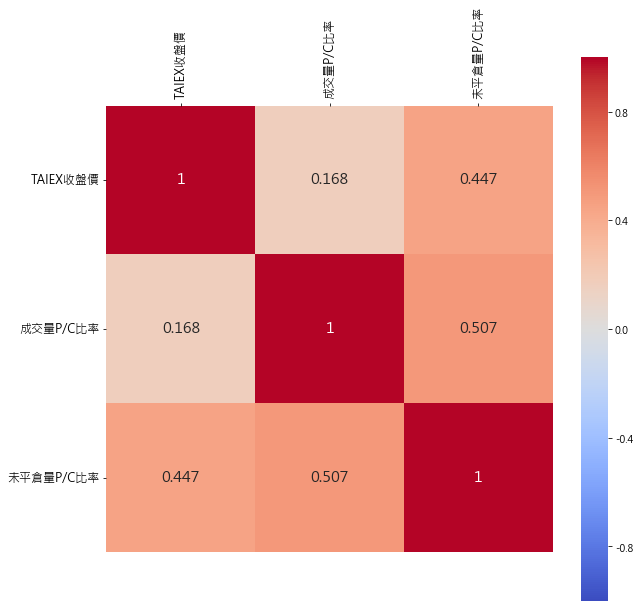

In [11]:
fig,ax=plt.subplots(1,figsize=(10,10))
sns.heatmap(corr,ax=ax,square=True,vmax=1.0,vmin=-1.0,linecolor='white',
            cmap='coolwarm',annot=True,annot_kws={'size':15},fmt='.3g')
ax.set_xticklabels(df.columns,rotation=90,fontsize=12)
ax.set_yticklabels(df.columns,fontsize=12,rotation=360,va='center')
ax.xaxis.tick_top()